# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.97133071128034443

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd-/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

            

In [ ]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [8, 32, 122]
        hidden_layers_arr = [3, 5]

        epochs = [15]
        lrs = [1e-2, 1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_only_nsl_kdd_all-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_all-.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_only_nsl_kdd_all-.pkl")

        

In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.552714 | Test Loss: 1.299611 | Test Accuracy: 0.836054, 0.693671
Step 2 | Training Loss: 0.327759 | Test Loss: 1.263373 | Test Accuracy: 0.848563, 0.729030
Step 3 | Training Loss: 0.298136 | Test Loss: 1.266813 | Test Accuracy: 0.788769, 0.616287
Step 4 | Training Loss: 0.287065 | Test Loss: 1.274246 | Test Accuracy: 0.791208, 0.614008
Step 5 | Training Loss: 0.328879 | Test Loss: 1.238946 | Test Accuracy: 0.859652, 0.743376
Step 6 | Training Loss: 0.807737 | Test Loss: 1.318154 | Test Accuracy: 0.798084, 0.757384
Step 7 | Training Loss: 0.335529 | Test Loss: 1.312963 | Test Accuracy: 0.753238, 0.770549
Step 8 | Training Loss: 0.250874 | Test Loss: 1.293152 | Test Accuracy: 0.786418, 0.756371
Step 9 | Training Loss: 0.645604 | Test Loss: 1.303067 | Test Accuracy: 0.812810, 0.782616
Step 10 | Training Loss: 0.262092 | Test Loss: 1.277885 | Test Accuracy: 0.836941, 0.794008
Step 11 | Training 

Step 15 | Training Loss: 0.727415 | Test Loss: 1.512378 | Test Accuracy: 0.518098, 0.266076
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 1.390387 | Test Loss: 8386.699219 | Test Accuracy: 0.766324, 0.564304
Step 2 | Training Loss: 0.433754 | Test Loss: 1.323542 | Test Accuracy: 0.771780, 0.572489
Step 3 | High Training Loss: 1758258432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-2
Step 3 | Training Loss: 0.545112 | Test Loss: 1.287345 | Test Accuracy: 0.768054, 0.565316
Step 4 | Training Loss: 0.640379 | Test Loss: 104411656071097090048.000000 | Test Accuracy: 0.565694, 0.358143
Step 5 | High Training Loss: 190560960512.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-2
Step 5 | Training Loss: 0.529771 | Test Loss: 1.244557 | Test Accuracy: 0.783534, 0.598312


Step 9 | Training Loss: 0.934280 | Test Loss: 1.515250 | Test Accuracy: 0.683242, 0.509114
Step 10 | Training Loss: 0.819372 | Test Loss: 1.514417 | Test Accuracy: 0.683242, 0.509114
Step 11 | Training Loss: 2.004886 | Test Loss: 1.515197 | Test Accuracy: 0.683242, 0.509114
Step 12 | Training Loss: 0.908459 | Test Loss: 1.514327 | Test Accuracy: 0.683242, 0.509114
Step 13 | Training Loss: 0.861360 | Test Loss: 1.516012 | Test Accuracy: 0.683242, 0.509114
Step 14 | Training Loss: 0.641588 | Test Loss: 1.514983 | Test Accuracy: 0.683242, 0.509114
Step 15 | Training Loss: 0.687788 | Test Loss: 1.515020 | Test Accuracy: 0.683242, 0.509114
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.678728 | Test Loss: 1.369356 | Test Accuracy: 0.830154, 0.682025
Step 2 | High Training Loss: 2103799.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-1
Step 2 | Training Lo

Step 7 | High Training Loss: 434937088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-6
Step 7 | Training Loss: 0.770745 | Test Loss: 1.347716 | Test Accuracy: 0.799459, 0.620338
Step 8 | Training Loss: 0.569455 | Test Loss: 1.481175 | Test Accuracy: 0.780917, 0.674346
Step 9 | Training Loss: 1.141554 | Test Loss:    nan | Test Accuracy: 0.863778, 0.753586
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-9
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-9
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-9
Step 10 | Training Loss: 0.971288 | Test Loss: 1.473903 |

Step 10 | Training Loss: 0.834784 | Test Loss: 1.401907 | Test Accuracy: 0.765614, 0.602785
Step 11 | Training Loss: 0.665292 | Test Loss: 1.395282 | Test Accuracy: 0.784510, 0.637722
Step 12 | Training Loss: 0.717311 | Test Loss: 1.396734 | Test Accuracy: 0.786728, 0.641688
Step 13 | Training Loss: 2.524521 | Test Loss: 1.392678 | Test Accuracy: 0.785353, 0.639241
Step 14 | Training Loss: 0.752183 | Test Loss: 1.392790 | Test Accuracy: 0.778478, 0.631224
Step 15 | Training Loss: 0.770535 | Test Loss: 1.390822 | Test Accuracy: 0.768142, 0.621941
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.493188 | Test Loss: 1.230101 | Test Accuracy: 0.813343, 0.650211
Step 2 | Training Loss: 0.372660 | Test Loss: 8093281836803658222665728.000000 | Test Accuracy: 0.796487, 0.756456
Step 3 | Training Loss: 0.505863 | Test Loss: 1.215273 | Test Accuracy: 0.850648, 0.752405
Step 4 | Training Loss: 0.381986 | Test Loss: 1.254912 | Test Accuracy: 0.850603

Step 15 | Training Loss: 0.691416 | Test Loss: 1.551580 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.926644 | Test Loss: 1.551475 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 1.453987 | Test Loss: 1.551483 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.845105 | Test Loss: 1.551644 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.649542 | Test Loss: 1.551532 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 1.064312 | Test Loss: 1.551416 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.855433 | Test Loss: 1.551260 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.853674 | Test Loss: 1.551361 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.794409 | Test Loss: 1.551449 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 1.001285 | Test Loss: 1.551492 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.812414 | Test Loss: 1.551523 | Test Accuracy: 0.430758, 0.1816

Step 8 | Training Loss: 0.950342 | Test Loss: 1.550901 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.882370 | Test Loss: 1.550895 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.609719 | Test Loss: 1.553105 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 0.764109 | Test Loss: 1.551982 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 1.276124 | Test Loss: 1.552783 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.863494 | Test Loss: 1.551089 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.963717 | Test Loss: 1.551967 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 1.007255 | Test Loss: 1.552744 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.910169 | Test Loss: 1.551692 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.688762 | Test Loss: 1.551597 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.748573 | Test Loss: 1.551680 | Test Accuracy: 0.430758, 0.

Step 12 | Training Loss: 0.483632 | Test Loss: 1.347275 | Test Accuracy: 0.821017, 0.767342
Step 13 | Training Loss: 0.413235 | Test Loss: 1.351346 | Test Accuracy: 0.771336, 0.757890
Step 14 | Training Loss: 1.047251 | Test Loss: 1.369757 | Test Accuracy: 0.803717, 0.774093
Step 15 | Training Loss: 0.352973 | Test Loss: 1.520337 | Test Accuracy: 0.779365, 0.767089
Step 1 | Training Loss: 0.434831 | Test Loss: 1.466656 | Test Accuracy: 0.772889, 0.760338
Step 2 | Training Loss: 0.489580 | Test Loss: 1.343830 | Test Accuracy: 0.666386, 0.506920
Step 3 | Training Loss: 0.448887 | Test Loss: 1.432901 | Test Accuracy: 0.752129, 0.779578
Step 4 | Training Loss: 0.561215 | Test Loss: 1.451931 | Test Accuracy: 0.773155, 0.833840
Step 5 | Training Loss: 0.581047 | Test Loss: 1.479476 | Test Accuracy: 0.739798, 0.810886
Step 6 | Training Loss: 1.064411 | Test Loss: 1.395987 | Test Accuracy: 0.805314, 0.842785
Step 7 | High Training Loss: 3085005.750000 ... Restoring Net
INFO:tensorflow:Restorin

Step 15 | Training Loss: 0.229072 | Test Loss: 1.248858 | Test Accuracy: 0.827138, 0.731646
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.300537 | Test Loss: 1.352121 | Test Accuracy: 0.774397, 0.575274
Step 2 | High Training Loss: 540217114624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-1
Step 2 | Training Loss: 0.830145 | Test Loss: 1.345739 | Test Accuracy: 0.777812, 0.581688
Step 3 | Training Loss: 0.509829 | Test Loss: 1.352122 | Test Accuracy: 0.774086, 0.571983
Step 4 | Training Loss: 0.700011 | Test Loss: 1.365356 | Test Accuracy: 0.782514, 0.590717
Step 5 | Training Loss: 0.590919 | Test Loss: 1.396731 | Test Accuracy: 0.873181, 0.790042
Step 6 | High Training Loss: 278343.281250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-5
Step 6 | Training Loss: 0.6

Step 15 | Training Loss: 0.931930 | Test Loss: 1.530363 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 1.933663 | Test Loss: 1.529718 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 1.279512 | Test Loss: 1.529240 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.676928 | Test Loss: 1.529456 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.704271 | Test Loss: 1.529601 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 1.153424 | Test Loss: 1.529486 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.553187 | Test Loss: 1.529333 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.688200 | Test Loss: 1.529418 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.575986 | Test Loss: 1.529504 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.773966 | Test Loss: 1.529080 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.065987 | Test Loss: 1.529031 | Test Accuracy: 0.430758, 0.1816

Step 8 | Training Loss: 0.847514 | Test Loss: 1.549521 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.668589 | Test Loss: 1.556349 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.758403 | Test Loss: 1.551920 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 0.915279 | Test Loss: 1.550163 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 1.186998 | Test Loss: 1.554004 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 1.224385 | Test Loss: 1.552784 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.824766 | Test Loss: 1.551114 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.828600 | Test Loss: 1.555837 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 1.517585 | Test Loss: 1.551750 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 1.108627 | Test Loss: 1.551408 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.735137 | Test Loss: 1.551278 | Test Accuracy: 0.430758, 0.

Step 1 | Training Loss: 0.312700 | Test Loss: 1.324932 | Test Accuracy: 0.837473, 0.766498
Step 2 | Training Loss: 0.390207 | Test Loss: 1.312993 | Test Accuracy: 0.842796, 0.730295
Step 3 | Training Loss: 0.482585 | Test Loss: 1.368087 | Test Accuracy: 0.851757, 0.829873
Step 4 | Training Loss: 0.706182 | Test Loss: 1.353485 | Test Accuracy: 0.830820, 0.793840
Step 5 | Training Loss: 0.385853 | Test Loss: 1.352834 | Test Accuracy: 0.835699, 0.807342
Step 6 | Training Loss: 0.391236 | Test Loss: 1.370252 | Test Accuracy: 0.864088, 0.834852
Step 7 | High Training Loss: 968574208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-9
Step 7 | Training Loss: 0.526214 | Test Loss: 1.312661 | Test Accuracy: 0.867149, 0.756287
Step 8 | Training Loss: 0.624923 | Test Loss: 1.307955 | Test Accuracy: 0.869500, 0.761772
Step 9 | Training Loss: 0.357115 | Test Loss: 1.313650 | Test Accuracy: 0.863467, 0.751646
Step

Step 5 | Training Loss: 0.532828 | Test Loss: 1.382343 | Test Accuracy: 0.796664, 0.625148
Step 6 | Training Loss: 1.160862 | Test Loss: 1.392829 | Test Accuracy: 0.860007, 0.750464
Step 7 | Training Loss: 0.584041 | Test Loss: 1.387163 | Test Accuracy: 0.832771, 0.688439
Step 8 | Training Loss: 0.675643 | Test Loss: 1.429192 | Test Accuracy: 0.821815, 0.667679
Step 9 | Training Loss: 0.628915 | Test Loss: 1.442052 | Test Accuracy: 0.848873, 0.725823
Step 10 | Training Loss: 0.865210 | Test Loss: 1.428013 | Test Accuracy: 0.871984, 0.765907
Step 11 | Training Loss: 0.554103 | Test Loss: 1.416652 | Test Accuracy: 0.845413, 0.714599
Step 12 | Training Loss: 0.447047 | Test Loss: 1.411357 | Test Accuracy: 0.857301, 0.741603
Step 13 | Training Loss: 0.705485 | Test Loss: 1.374047 | Test Accuracy: 0.831086, 0.689536
Step 14 | Training Loss: 0.762259 | Test Loss: 1.364452 | Test Accuracy: 0.820351, 0.670211
Step 15 | Training Loss: 1.155909 | Test Loss: 1.448693 | Test Accuracy: 0.647889, 0.

Step 15 | Training Loss: 1.286623 | Test Loss: 1.551526 | Test Accuracy: 0.430758, 0.181603
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.620823 | Test Loss: 1.381585 | Test Accuracy: 0.761001, 0.550886
Step 2 | Training Loss: 0.569430 | Test Loss: 1.346165 | Test Accuracy: 0.741971, 0.518481
Step 3 | High Training Loss: 9550731.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-1
Step 3 | Training Loss: 2.355818 | Test Loss: 1.410146 | Test Accuracy: 0.788636, 0.603207
Step 4 | High Training Loss: 6481213952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-3
Step 4 | High Training Loss: 12074472.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-3
Step 4 | Training Loss: 0.639717 |

Step 9 | Training Loss: 0.353770 | Test Loss: 1.195584 | Test Accuracy: 0.826783, 0.709705
Step 10 | Training Loss: 0.274047 | Test Loss: 1.252494 | Test Accuracy: 0.843683, 0.719662
Step 11 | Training Loss: 0.316861 | Test Loss: 1.402910 | Test Accuracy: 0.786773, 0.699662
Step 12 | Training Loss: 0.355135 | Test Loss: 1.252950 | Test Accuracy: 0.834812, 0.743629
Step 13 | Training Loss: 0.648825 | Test Loss: 1.254657 | Test Accuracy: 0.800257, 0.721181
Step 14 | Training Loss: 0.493778 | Test Loss: 1.325425 | Test Accuracy: 0.817557, 0.700422
Step 15 | Training Loss: 0.233371 | Test Loss: 1.327368 | Test Accuracy: 0.784155, 0.733418
Step 1 | Training Loss: 0.286504 | Test Loss: 1.371553 | Test Accuracy: 0.834058, 0.717553
Step 2 | Training Loss: 0.414399 | Test Loss: 1.392800 | Test Accuracy: 0.789966, 0.738987
Step 3 | Training Loss: 0.360898 | Test Loss: 1.342965 | Test Accuracy: 0.750532, 0.762616
Step 4 | Training Loss: 0.468668 | Test Loss: 1.377467 | Test Accuracy: 0.751286, 0.

Step 1 | Training Loss: 0.643704 | Test Loss: 1.407896 | Test Accuracy: 0.681112, 0.483122
Step 2 | Training Loss: 0.647761 | Test Loss: 1.389117 | Test Accuracy: 0.705066, 0.524051
Step 3 | Training Loss: 0.772151 | Test Loss: 1.384268 | Test Accuracy: 0.696771, 0.510886
Step 4 | Training Loss: 0.531283 | Test Loss: 1.367617 | Test Accuracy: 0.799814, 0.630886
Step 5 | Training Loss: 2.240987 | Test Loss: 1.362291 | Test Accuracy: 0.808419, 0.638734
Step 6 | Training Loss: 0.647415 | Test Loss: 1.359338 | Test Accuracy: 0.810859, 0.643460
Step 7 | Training Loss: 0.411395 | Test Loss: 1.351817 | Test Accuracy: 0.785220, 0.592827
Step 8 | Training Loss: 0.623614 | Test Loss: 1.350957 | Test Accuracy: 0.806645, 0.636456
Step 9 | Training Loss: 0.682596 | Test Loss: 1.379021 | Test Accuracy: 0.807798, 0.671308
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-6
Step 10 | Traini

Step 9 | Training Loss: 0.802357 | Test Loss: 1.551158 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.052963 | Test Loss: 1.550901 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 1.232134 | Test Loss: 1.552623 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 0.721755 | Test Loss: 1.551955 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.776363 | Test Loss: 1.552027 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.863115 | Test Loss: 1.550340 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.631271 | Test Loss: 1.552808 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.927276 | Test Loss: 1.551746 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.693970 | Test Loss: 1.551547 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.949231 | Test Loss: 1.551862 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.621353 | Test Loss: 1.551408 | Test Accuracy: 0.430758, 0.

Step 12 | High Training Loss: 20684562408308432382722048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 12 | High Training Loss: 2844700.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 12 | Training Loss: 0.744478 | Test Loss: 1534969503547392.000000 | Test Accuracy: 0.844438, 0.731646
Step 13 | High Training Loss: 2475336704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 13 

Step 2 | Training Loss: 0.554856 | Test Loss: 1.365374 | Test Accuracy: 0.778655, 0.767004
Step 3 | Training Loss: 0.668118 | Test Loss: 1.364601 | Test Accuracy: 0.776526, 0.766498
Step 4 | Training Loss: 0.809551 | Test Loss: 1.363626 | Test Accuracy: 0.775594, 0.765823
Step 5 | Training Loss: 0.588470 | Test Loss: 1.362879 | Test Accuracy: 0.775727, 0.766498
Step 6 | Training Loss: 0.481593 | Test Loss: 1.362615 | Test Accuracy: 0.774485, 0.765654
Step 7 | Training Loss: 0.557693 | Test Loss: 1.355833 | Test Accuracy: 0.771647, 0.756709
Step 8 | Training Loss: 0.310012 | Test Loss: 1.352923 | Test Accuracy: 0.771425, 0.761772
Step 9 | Training Loss: 0.350582 | Test Loss: 1.350537 | Test Accuracy: 0.770360, 0.759072
Step 10 | Training Loss: 0.363989 | Test Loss: 1.346157 | Test Accuracy: 0.782470, 0.757975
Step 11 | Training Loss: 0.465603 | Test Loss: 1.347308 | Test Accuracy: 0.781050, 0.758734
Step 12 | Training Loss: 0.283378 | Test Loss: 1.347800 | Test Accuracy: 0.778566, 0.759

Step 11 | Training Loss: 0.688219 | Test Loss: 1.299405 | Test Accuracy: 0.818000, 0.661266
Step 12 | Training Loss: 0.435999 | Test Loss: 1.362951 | Test Accuracy: 0.793825, 0.650127
Step 13 | Training Loss: 0.447778 | Test Loss: 1.333524 | Test Accuracy: 0.767344, 0.564219
Step 14 | Training Loss: 0.313072 | Test Loss: 1.411454 | Test Accuracy: 0.712030, 0.645316
Step 15 | Training Loss: 0.625891 | Test Loss: 1.371943 | Test Accuracy: 0.755944, 0.548017
Step 1 | Training Loss: 1.044543 | Test Loss: 1.438124 | Test Accuracy: 0.560016, 0.366582
Step 2 | High Training Loss: 11812.066406 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 2 | Training Loss: 0.381953 | Test Loss: 1.404905 | Test Accuracy: 0.725160, 0.570042
Step 3 | Training Loss: 0.666321 | Test Loss: 1.390275 | Test Accuracy: 0.837252, 0.721097
Step 4 | Training Loss: 0.517036 | Test Loss: 1.393770 | Test Accuracy: 0.810814, 0.766329
St

Step 13 | High Training Loss: 35790.585938 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 13 | High Training Loss: 144625408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-11
Step 13 | Training Loss: 1.255334 | Test Loss: 1.483323 | Test Accuracy: 0.865907, 0.792743
Step 14 | Training Loss: 0.681569 | Test Loss: 1.482564 | Test Accuracy: 0.847853, 0.747004
Step 15 | Training Loss: 2.301574 | Test Loss: 1.550964 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.852145 | Test Loss: 1.551156 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.633393 | Test Loss: 1.551598 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 1.031383 | Test Loss: 1.551314 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.950645 | Test Loss: 1.551467 | Test Accuracy: 0.430758, 0.181603
Step 5

Step 8 | Training Loss: 0.681708 | Test Loss: 1.472334 | Test Accuracy: 0.852732, 0.822532
Step 9 | Training Loss: 1.649737 | Test Loss: 1.470541 | Test Accuracy: 0.854729, 0.824557
Step 10 | Training Loss: 0.580545 | Test Loss: 1.470618 | Test Accuracy: 0.839425, 0.818987
Step 11 | Training Loss: 0.614099 | Test Loss: 1.464321 | Test Accuracy: 0.854285, 0.827173
Step 12 | Training Loss: 0.739415 | Test Loss: 1.467587 | Test Accuracy: 0.841554, 0.826582
Step 13 | Training Loss: 0.630392 | Test Loss: 1.468397 | Test Accuracy: 0.839869, 0.822785
Step 14 | Training Loss: 0.401966 | Test Loss: 1.463432 | Test Accuracy: 0.845014, 0.797384
Step 15 | Training Loss: 2.609883 | Test Loss: 1.503835 | Test Accuracy: 0.833792, 0.771477
Step 1 | Training Loss: 0.874572 | Test Loss: 1.489451 | Test Accuracy: 0.846345, 0.770295
Step 2 | Training Loss: 0.613028 | Test Loss: 1.489137 | Test Accuracy: 0.846256, 0.768945
Step 3 | Training Loss: 1.274749 | Test Loss: 1.488600 | Test Accuracy: 0.847365, 0.

Step 10 | Training Loss: 0.424243 | Test Loss: 1.355097 | Test Accuracy: 0.802963, 0.641857
Step 11 | Training Loss: 1.041645 | Test Loss: 1.352244 | Test Accuracy: 0.823900, 0.671055
Step 12 | Training Loss: 0.334155 | Test Loss: 1.364884 | Test Accuracy: 0.844304, 0.707257
Step 13 | Training Loss: 0.660064 | Test Loss: 1.439497 | Test Accuracy: 0.772667, 0.575190
Step 14 | Training Loss: 0.715441 | Test Loss: 1.466594 | Test Accuracy: 0.626331, 0.380928
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-12
Step 15 | Training Loss: 0.797817 | Test Loss: 1.386381 | Test Accuracy: 0.711586, 0.490549
Step 1 | Training Loss: 0.660335 | Test Loss: 1.546382 | Test Accuracy: 0.506166, 0.317722
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-12
Step 2 | Training Loss: 1.

Step 3 | Training Loss: 0.675472 | Test Loss: 1.404662 | Test Accuracy: 0.748935, 0.564051
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-1
Step 4 | High Training Loss: 113550475264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-1
Step 4 | Training Loss: 0.597361 | Test Loss: 1.380028 | Test Accuracy: 0.786418, 0.596709
Step 5 | Training Loss: 0.520051 | Test Loss: 1.357463 | Test Accuracy: 0.763086, 0.555106
Step 6 | High Training Loss: 89588.414062 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_5/model-1
Step 6 | Training Loss: 1.028935 | Test Loss: 1.381686 | Test Accuracy: 0.746451, 0.524726
Step 7 | Training Loss: 1.182948 | Test Loss: 1.390557 | Test Accuracy: 0.785486, 0.600422
Step 8 | Training Loss: 1.01

Step 15 | Training Loss: 0.619961 | Test Loss: 1.647844 | Test Accuracy: 0.833747, 0.726329
Step 1 | Training Loss: 0.654479 | Test Loss: 1.419993 | Test Accuracy: 0.827094, 0.696287
Step 2 | Training Loss: 2.554837 | Test Loss: 1.396272 | Test Accuracy: 0.843417, 0.718059
Step 3 | Training Loss: 0.809608 | Test Loss: 1.386284 | Test Accuracy: 0.848385, 0.722616
Step 4 | Training Loss: 0.679347 | Test Loss: 1.381862 | Test Accuracy: 0.846079, 0.718481
Step 5 | Training Loss: 1.199956 | Test Loss: 1.385239 | Test Accuracy: 0.837961, 0.703207
Step 6 | Training Loss: 0.621584 | Test Loss: 1.368522 | Test Accuracy: 0.836276, 0.698481
Step 7 | Training Loss: 0.504867 | Test Loss: 1.374263 | Test Accuracy: 0.834147, 0.695105
Step 8 | Training Loss: 0.641693 | Test Loss: 1.354476 | Test Accuracy: 0.834768, 0.698312
Step 9 | Training Loss: 0.855173 | Test Loss: 1.349013 | Test Accuracy: 0.846256, 0.719747
Step 10 | Training Loss: 0.531103 | Test Loss: 1.344257 | Test Accuracy: 0.827981, 0.6846

Step 12 | Training Loss: 2.216984 | Test Loss: 1.551938 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.901030 | Test Loss: 1.551836 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.915721 | Test Loss: 1.551300 | Test Accuracy: 0.430758, 0.181519
Step 15 | Training Loss: 0.933748 | Test Loss: 1.551729 | Test Accuracy: 0.430758, 0.181519
Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 1.388950 | Test Loss: 1.296806 | Test Accuracy: 0.802431, 0.628776
Step 2 | Training Loss: 0.411549 | Test Loss: 1.315676 | Test Accuracy: 0.764594, 0.560591
Step 3 | Training Loss: 0.584543 | Test Loss: 1.328704 | Test Accuracy: 0.790232, 0.616456
Step 4 | Training Loss: 0.672969 | Test Loss: 1.284620 | Test Accuracy: 0.771469, 0.568270
Step 5 | Training Loss: 0.241465 | Test Loss: 1.290635 | Test Accuracy: 0.790587, 0.612911
Step 6 | Training Loss: 0.155407 | Test Loss: 1.258551 | Test Accuracy: 0.792095, 0.620928
Step 7 | Trainin

Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd-/hidden layers_15_features count_3/model-5
Step 7 | Training Loss: 0.760000 | Test Loss: 1.387659 | Test Accuracy: 0.849805, 0.732658
Step 8 | Training Loss: 0.641592 | Test Loss: 1.380060 | Test Accuracy: 0.869766, 0.765823
Step 9 | Training Loss: 0.646657 | Test Loss: 1.398342 | Test Accuracy: 0.876996, 0.784388
Step 10 | Training Loss: 1.578074 | Test Loss: 1.402152 | Test Accuracy: 0.882896, 0.790127
Step 11 | Training Loss: 0.595465 | Test Loss: 1.449758 | Test Accuracy: 0.838183, 0.749705
Step 12 | Training Loss: 0.564673 | Test Loss: 1.409976 | Test Accuracy: 0.863423, 0.791730
Step 13 | Training Loss: 0.623909 | Test Loss: 1.412987 | Test Accuracy: 0.865951, 0.757553
Step 14 | Training Loss: 0.671043 | Test Loss: 1.473839 | Test Accuracy: 0.704755, 0.520760
Step 15 | Training Loss: 0.796237 | Test Loss: 1.496351 | Test Accuracy: 0.703380, 0.523207
Step 1 | Tr

In [23]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,122,3,0.921429,0.888352,0.793840,53.792756
1,45,32,3,0.888492,0.881432,0.811730,32.880156
3,45,8,5,0.912302,0.864709,0.750633,8.846254


In [24]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,122,3,0.921429,0.888352,0.793840,53.792756
1,45,32,3,0.888492,0.881432,0.811730,32.880156
5,45,122,5,0.911111,0.865153,0.749620,30.550306
3,45,8,5,0.912302,0.864709,0.750633,8.846254
0,45,8,3,0.861905,0.836852,0.712658,67.258506
4,45,32,5,0.962698,0.788281,0.601772,9.211589


In [25]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores-.pkl")

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9211  0.0789]
 [ 0.1047  0.8953]]


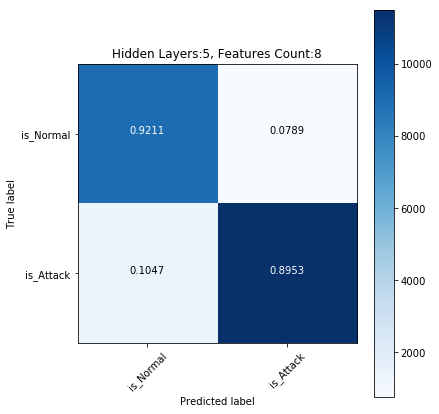

In [27]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7351  0.2649]
 [ 0.1385  0.8615]]


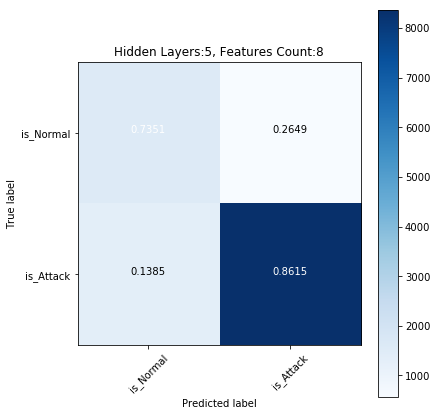

In [28]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [20]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
8,3,45,0.938095,0.834235,0.745738,4.142243
32,3,45,0.935714,0.867858,0.803629,7.304822
122,3,45,0.931349,0.893763,0.808608,5.388218
8,5,45,0.919841,0.875887,0.770802,28.297642
32,5,45,0.742857,0.846212,0.805570,30.459472
122,5,45,0.920238,0.845635,0.725992,14.206433
8,3,45,0.938095,0.834235,0.745738,4.142243
32,3,45,0.935714,0.867858,0.803629,7.304822
122,3,45,0.931349,0.893763,0.808608,5.388218


In [21]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
8              3                 45     0.947189    0.861293       0.760527   
               5                 45     0.912103    0.866576       0.757785   
32             3                 45     0.929696    0.868520       0.775872   
               5                 45     0.880522    0.856592       0.761660   
122            3                 45     0.902844    0.801433       0.668748   
               5                 45     0.890509    0.845909       0.729248   

                              time_taken  
no_of_features hidden_layers              
8              3               29.313401  
               5               29.432164  
32             3               28.849374  
               5               21.603482  
122            3               20.888488  
               5               32.712729

In [22]:
pgb.std()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
8              3                0.0     0.009183    0.020081       0.032942   
               5                0.0     0.031370    0.026050       0.053782   
32             3                0.0     0.017571    0.011122       0.025878   
               5                0.0     0.067652    0.024372       0.054613   
122            3                0.0     0.042117    0.128029       0.181638   
               5                0.0     0.047513    0.034149       0.071352   

                              time_taken  
no_of_features hidden_layers              
8              3               21.820696  
               5               11.310540  
32             3               24.257905  
               5               14.117080  
122            3               22.398200  
               5               34.583974